In [1]:
import numpy as np
import pandas as pd
import cmath
import matplotlib.pyplot as plt

# Reading in files

In [2]:
# All up to date copies of the index of refraction .csv files are in the From_Max_Copy folder
directory = "/Users/rebeccazhang/Documents/Polarimetry/Research/DSP/Programs/From_Max_Copy/"

# Reading in all indices of refraction as 
n_silver_list = pd.read_csv("silver_n.csv")
n_quartz_list = pd.read_csv("Gao.csv")
n_o_quartz_list = pd.read_csv("Ghosh-o.csv")
n_e_quartz_list = pd.read_csv("Ghosh-e.csv")
n_air_list = pd.read_csv("Ciddor.csv")
n_o_MgF2_list = pd.read_csv("MgF2_Dodge_n_o.csv")
n_e_MgF2_list = pd.read_csv("MgF2_Dodge_n_e.csv")

# For the imaginary part of silver's refractive index
k_silver_list = pd.read_csv("silver_k.csv")

# Turning all pandas dataframes 
n_silver_list = pd.DataFrame(n_silver_list).to_numpy()
n_quartz_list = pd.DataFrame(n_quartz_list).to_numpy()
n_o_quartz_list = pd.DataFrame(n_o_quartz_list).to_numpy()
n_e_quartz_list = pd.DataFrame(n_e_quartz_list).to_numpy()
n_air_list = pd.DataFrame(n_air_list).to_numpy()
n_o_MgF2_list = pd.DataFrame(n_o_MgF2_list).to_numpy()
n_e_MgF2_list = pd.DataFrame(n_e_MgF2_list).to_numpy()

# For the imaginary part of silver's refractive index
k_silver_list = pd.DataFrame(k_silver_list).to_numpy()

# Reformating the last value for float conversion - does not affect VAMPIRES model as not within notable
# wavelength range
n_quartz_list[500, 0] = 0
n_quartz_list[500, 1] = 0

# Converting all pandas dataframes into numpy arrays
n_silver_list = np.asarray(n_silver_list, dtype = float)
n_quartz_list = np.asarray(n_quartz_list, dtype = float)
n_o_quartz_list = np.asarray(n_o_quartz_list, dtype = float)
n_e_quartz_list = np.asarray(n_e_quartz_list, dtype = float)
k_silver_list = np.asarray(k_silver_list, dtype = float)
n_o_MgF2_list = np.asarray(n_o_MgF2_list, dtype = float)
n_e_MgF2_list = np.asarray(n_e_MgF2_list, dtype = float)

FileNotFoundError: [Errno 2] No such file or directory: 'silver_n.csv'

# return_n function for all the relevant materials

In [17]:
# wavelength given in um
def return_n(wavelength, material):
    if material == "silver":
        index = np.abs(n_silver_list[:, 0] - wavelength).argmin()
        n = n_silver_list[index, 1] + k_silver_list[index, 1] * 1j
    if material == "quartz":
        index = np.abs(n_quartz_list[:, 0] - wavelength).argmin()
        n = n_quartz_list[index, 1]
    if material == "quartz_n_e":
        n = (1 + 0.28851804 + 1.09509924 / (1 - 1.02101864e-2 / wavelength ** 2) + 1.15662475 / \
        (1 - 100 / wavelength ** 2)) ** .5
    if material == "quartz_n_o":
        n = (1 + 0.28604141 + 1.07044083 / (1 - 1.00585997e-2 / wavelength ** 2) + 1.10202242 / \
        (1 - 100 / wavelength ** 2)) ** .5
    if material == "air":
        n = 1 + 0.05792105 / (238.0185 - wavelength ** -2) + 0.00167917 / (57.362 - wavelength ** -2)
    if material == "MgF2_n_o":
        n = (1 + 0.48755108 / (1 - (0.04338408 / wavelength) ** 2) + 0.39875031 / (1 - (0.09461442 / \
        wavelength) ** 2) + 2.3120353 / (1 - (23.793604 / wavelength) ** 2)) ** .5
    if material == "MgF2_n_e":
        n = (1 + 0.41344023 / (1 - (0.03684262 / wavelength) ** 2) + 0.50497499 / (1 - (0.09076162 / \
        wavelength) ** 2) + 2.4904862 / (1 - (23.771995 / wavelength) ** 2)) ** .5
    return n

# Returning HWP retardance as per Joost 't Hart paper

In [18]:
def HWP_retardance(wavelengths, w_SiO2, w_MgF2):
    '''
    Returns the HWP retardance based on eq. 23 from Joost 't Hart 2021

    Args:
        wavelengths: (float list) list of wavelengths (nm)
        w_SiO2: (float) width of SiO2 layer (mm)
        w_MgF2: (float) width of MgF2 layer (mm)

    Returns:
        retardance_list: (float list) list of all corresponding retardances (rad)
    '''

    # Converting input wavelength from nm to um
    wavelengths = wavelengths / 10 ** 3

    # Converting input widths from mm to um
    w_SiO2 = w_SiO2 * 10 ** 3
    w_MgF2 = w_MgF2 * 10 ** 3

    retardance_list = []
    
    for wavelength in wavelengths:
        retardance = 2 * np.pi / wavelength * (w_SiO2 * (return_n(wavelength, \
            "quartz_n_e") - return_n(wavelength, "quartz_n_o")) - w_MgF2 * \
            (return_n(wavelength, "MgF2_n_e") - return_n(wavelength, "MgF2_n_o")))
        if retardance < 0:
            retardance = -retardance
        retardance_list.append(retardance)

    retardance_list = np.array(retardance_list)
    
    # Converting from radians to waves
    retardance_list = retardance_list / (2 * np.pi)

    return retardance_list

In [19]:
# Testing HWP retardance
# Values from Joost_Hart, Table 1
w_SiO2 = 1.623 # in mm
w_MgF2 = 1.268 # in mm

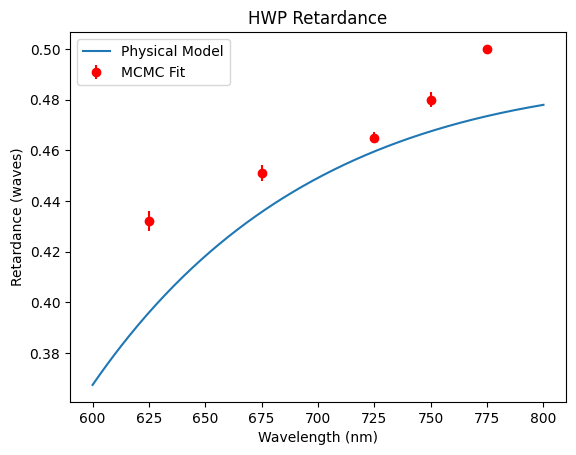

In [20]:
wavelengths = np.linspace(600, 800, 250)

retardances = HWP_retardance(wavelengths, w_SiO2, w_MgF2)

plt.title('HWP Retardance')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Retardance (waves)")

plt.plot(wavelengths, retardances, label = "Physical Model")

MCMC_wavelengths = np.array([625, 675, 725, 750, 775])
MCMC_HWP_retardances = np.array([0.432, 0.451, 0.465, 0.48, 0.5])
MCMC_HWP_errors = np.array([0.004, 0.003, 0.002, 0.003, 0])
plt.errorbar(MCMC_wavelengths, MCMC_HWP_retardances, yerr = MCMC_HWP_errors, marker = 'o', color = "red", linestyle = "None", label = "MCMC Fit")
plt.legend()


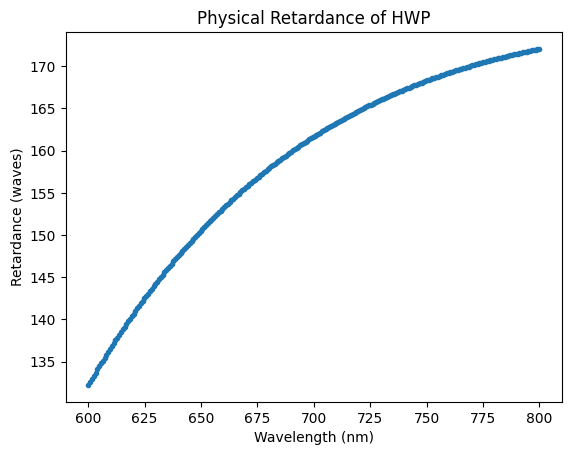

In [21]:
plt.title('Physical Retardance of HWP')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Retardance (waves)")
HWP_retardance_degrees = np.degrees(retardances * 2 * np.pi)

plt.plot(wavelengths, HWP_retardance_degrees, marker = '.', linestyle = "None")



# Fresnel Functions

In [22]:
def snell(n1, n2, theta):
    return np.arcsin(n1 * np.sin(theta) / n2)

def r_s(n1, n2, theta_i, theta_t):
    return (n1 * np.cos(theta_i) - n2 * np.cos(theta_t)) / (n1 * np.cos(theta_i) + n2 * np.cos(theta_t))

def r_p(n1, n2, theta_i, theta_t):
    return (n2 * np.cos(theta_i) - n1 * np.cos(theta_t)) / (n2 * np.cos(theta_i) + n1 * np.cos(theta_t))

def t_s(n1, n2, theta_i, theta_t):
    return 2 * n1 * np.cos(theta_i) / (n1 * np.cos(theta_i) + n2 * np.cos(theta_t))

def t_p(n1, n2, theta_i, theta_t):
    return 2 * n1 * np.cos(theta_i) / (n2 * np.cos(theta_i) + n1 * np.cos(theta_t))

def r_tot(r01, r10, r12, t01, t10, beta):
    return r01 + (t01 * t10 * r12 * np.exp(beta * 1j)) / (1 - r10 * r12 * np.exp(beta * 1j))

# n is for quartz
def beta(wavelength, d, n, theta):
    return 2 * 2 * np.pi / wavelength * d * n * np.cos(theta)

def retardance(r_tot_s, r_tot_p):
    return cmath.phase(r_tot_s) - cmath.phase(r_tot_p)

# Set-Up for IMR Retardance

In [23]:
def IMR_retardance(d, wavelengths):
    """
    Returns the IMR retardance based on eq. 18 - 21 from Joost 't Hart 2021

    Args:
        d: (float) thickness of the quartz layer (nm)
        wavelengths: (float list) incident wavelengths (nm)

    Returns:
        retardance_list: (float list) corresponding retardances (waves)
    """

    # Converting input wavelength from nm to um
    wavelengths = wavelengths / 10.0 ** 3
    d = d / 10.0 ** 3

    retardance_list = []

    for wavelength in wavelengths:
        n_silver = return_n(wavelength, "silver")
        n_quartz = return_n(wavelength, "quartz")
        n_air = return_n(wavelength, "air")

        # For the air to quartz transition: 30 degrees
        
        theta_t_01_30 = snell(n_air, n_quartz, np.radians(30))
        
        r_s_01_30 = r_s(n_air, n_quartz, np.radians(30), theta_t_01_30)
        r_p_01_30 = r_p(n_air, n_quartz, np.radians(30), theta_t_01_30)
        
        t_s_01_30 = t_s(n_air, n_quartz, np.radians(30), theta_t_01_30)
        t_p_01_30 = t_p(n_air, n_quartz, np.radians(30), theta_t_01_30)
        
        # For the air to quartz transition: 60 degrees
        
        theta_t_01_60 = snell(n_air, n_quartz, np.radians(60))
        
        r_s_01_60 = r_s(n_air, n_quartz, np.radians(60), theta_t_01_60)
        r_p_01_60 = r_p(n_air, n_quartz, np.radians(60), theta_t_01_60)
        
        t_s_01_60 = t_s(n_air, n_quartz, np.radians(60), theta_t_01_60)
        t_p_01_60 = t_p(n_air, n_quartz, np.radians(60), theta_t_01_60)
        
        # For the air to quartz transition: 30 degrees
        
        theta_t_10_30 = snell(n_quartz, n_air, np.radians(30))
        
        r_s_10_30 = r_s(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
        r_p_10_30 = r_p(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
        
        t_s_10_30 = t_s(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
        t_p_10_30 = t_p(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
        
        # For the air to quartz transition: 60 degrees
        
        r_s_10_60 = r_s(n_quartz, n_air, theta_t_01_60, np.radians(60))
        r_p_10_60 = r_p(n_quartz, n_air, theta_t_01_60, np.radians(60))
        
        t_s_10_60 = t_s(n_quartz, n_air, theta_t_01_60, np.radians(60))
        t_p_10_60 = t_p(n_quartz, n_air, theta_t_01_60, np.radians(60))
        
        # For the quartz to silver transition: 30 degrees
        
        theta_t_12_30 = snell(n_quartz, n_silver, theta_t_01_30)
        
        r_s_12_30 = r_s(n_quartz, n_silver, theta_t_01_30, theta_t_12_30)
        r_p_12_30 = r_p(n_quartz, n_silver, theta_t_01_30, theta_t_12_30)
        
        # For the quartz to silver transition: 60 degrees
        
        theta_t_12_60 = snell(n_quartz, n_silver, theta_t_01_60)
        
        r_s_12_60 = r_s(n_quartz, n_silver, theta_t_01_60, theta_t_12_60)
        r_p_12_60 = r_p(n_quartz, n_silver, theta_t_01_60, theta_t_12_60)
        
        # Betas for 30 and 60 degrees
        
        beta_30 = beta(wavelength, d, n_quartz, theta_t_01_30)
        beta_60 = beta(wavelength, d, n_quartz, theta_t_01_60)
        
        # r_tot for s and p polarization
        
        r_s_tot_30 = r_tot(r_s_01_30, r_s_10_30, r_s_12_30, t_s_01_30, t_s_10_30, \
            beta_30)
        r_s_tot_60 = r_tot(r_s_01_60, r_s_10_60, r_s_12_60, t_s_01_60, t_s_10_60, \
            beta_60)
        r_s_tot = r_s_tot_60 * r_s_tot_30 * r_s_tot_60
        
        r_p_tot_30 = r_tot(r_p_01_30, r_p_10_30, r_p_12_30, t_p_01_30, t_p_10_30, \
            beta_30)
        r_p_tot_60 = r_tot(r_p_01_60, r_p_10_60, r_p_12_60, t_p_01_60, t_p_10_60, \
            beta_60)
        r_p_tot = r_p_tot_60 * r_p_tot_30 * r_p_tot_60
        
        final_retardance = final_IMR_retardance(r_s_tot, r_p_tot)
        if final_retardance < 0:
            final_retardance = final_retardance + 2 * np.pi
        
        retardance_list.append(final_retardance)

    # print("r_s_tot: " + str(r_s_tot))
    # print("r_p_tot: " + str(r_p_tot))

    # Converting from radians to waves

    retardance_list = np.array(retardance_list)
    retardance_list = retardance_list / (2 * np.pi)

    return retardance_list

In [24]:
# All lengths are expressed in um!

wavelengths = np.array([0.5])
d = 0.26256

retardances = []

for wavelength in wavelengths:
    print("Wavelength: " + str(wavelength))
    n_silver = return_n(wavelength, "silver")
    n_quartz = return_n(wavelength, "quartz")
    n_air = return_n(wavelength, "air")
    
    # For the air to quartz transition: 30 degrees
    
    theta_t_01_30 = snell(n_air, n_quartz, np.radians(30))
    
    r_s_01_30 = r_s(n_air, n_quartz, np.radians(30), theta_t_01_30)
    r_p_01_30 = r_p(n_air, n_quartz, np.radians(30), theta_t_01_30)
    
    t_s_01_30 = t_s(n_air, n_quartz, np.radians(30), theta_t_01_30)
    t_p_01_30 = t_p(n_air, n_quartz, np.radians(30), theta_t_01_30)
    
    # For the air to quartz transition: 60 degrees
    
    theta_t_01_60 = snell(n_air, n_quartz, np.radians(60))
    
    r_s_01_60 = r_s(n_air, n_quartz, np.radians(60), theta_t_01_60)
    r_p_01_60 = r_p(n_air, n_quartz, np.radians(60), theta_t_01_60)
    
    t_s_01_60 = t_s(n_air, n_quartz, np.radians(60), theta_t_01_60)
    t_p_01_60 = t_p(n_air, n_quartz, np.radians(60), theta_t_01_60)
    
    # TODO: Change this to be quartz to air
    # For the air to quartz transition: 30 degrees
    
    theta_t_10_30 = snell(n_quartz, n_air, np.radians(30))
    
    r_s_10_30 = r_s(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
    r_p_10_30 = r_p(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
    
    t_s_10_30 = t_s(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
    t_p_10_30 = t_p(n_quartz, n_air, theta_t_01_30, theta_t_10_30)
    
    # TODO: Change this to be quartz to air
    # For the air to quartz transition: 60 degrees
    
    # theta_t_10_60 = snell(n_quartz, n_air, np.radians(60))
    # print("theta_t_10_60: " + str(theta_t_10_60))
    
    r_s_10_60 = r_s(n_quartz, n_air, theta_t_01_60, np.radians(60))
    r_p_10_60 = r_p(n_quartz, n_air, theta_t_01_60, np.radians(60))
    
    t_s_10_60 = t_s(n_quartz, n_air, theta_t_01_60, np.radians(60))
    t_p_10_60 = t_p(n_quartz, n_air, theta_t_01_60, np.radians(60))
    
    # For the quartz to silver transition: 30 degrees
    
    theta_t_12_30 = snell(n_quartz, n_silver, theta_t_01_30)
    
    r_s_12_30 = r_s(n_quartz, n_silver, theta_t_01_30, theta_t_12_30)
    r_p_12_30 = r_p(n_quartz, n_silver, theta_t_01_30, theta_t_12_30)
    
    # For the quartz to silver transition: 60 degrees
    
    theta_t_12_60 = snell(n_quartz, n_silver, theta_t_01_60)
    
    r_s_12_60 = r_s(n_quartz, n_silver, theta_t_01_60, theta_t_12_60)
    r_p_12_60 = r_p(n_quartz, n_silver, theta_t_01_60, theta_t_12_60)
    
    # Betas for 30 and 60 degrees
    
    beta_30 = beta(wavelength, d, n_quartz, theta_t_01_30)
    beta_60 = beta(wavelength, d, n_quartz, theta_t_01_60)
    
    # r_tot for s and p polarization
    
    print(r_s_01_30, r_s_10_30, r_s_12_30, t_s_01_30, t_s_10_30, beta_30)
    print(r_s_01_60, r_s_10_60, r_s_12_60, t_s_01_60, t_s_10_60, beta_60)
    
    r_s_tot_30 = r_tot(r_s_01_30, r_s_10_30, r_s_12_30, t_s_01_30, t_s_10_30, beta_30)
    r_s_tot_60 = r_tot(r_s_01_60, r_s_10_60, r_s_12_60, t_s_01_60, t_s_10_60, beta_60)
    r_s_tot = r_s_tot_60 * r_s_tot_30 * r_s_tot_60
    
    r_p_tot_30 = r_tot(r_p_01_30, r_p_10_30, r_p_12_30, t_p_01_30, t_p_10_30, beta_30)
    r_p_tot_60 = r_tot(r_p_01_60, r_p_10_60, r_p_12_60, t_p_01_60, t_p_10_60, beta_60)
    r_p_tot = r_p_tot_60 * r_p_tot_30 * r_p_tot_60
    
    print("r_s_tot: " + str(r_s_tot))
    print("r_p_tot: " + str(r_p_tot))
    
    final_retardance = retardance(r_s_tot, r_p_tot)
    if final_retardance < 0:
        final_retardance = final_retardance + 2 * np.pi
    
    retardances.append(final_retardance)
    
retardances = np.array(retardances)
retardances = np.degrees(retardances)

def final_IMR_retardance(r_tot_s, r_tot_p):
    return cmath.phase(r_tot_s) - cmath.phase(r_tot_p)

Wavelength: 0.5
-0.23370161856808766 0.34958359672607975 (-0.5970009045271798-0.7556986519543774j) 0.7662983814319123 1.3495835967260796 9.203063555785416
-0.4123336607212808 0.4123336607212808 (-0.6953793366090147-0.6748249848592532j) 0.5876663392787191 1.4123336607212806 7.931696025482977
r_s_tot: (-0.27254990051770894-1.036474460156039j)
r_p_tot: (-0.8456216008808295-0.3333662568861957j)


In [25]:
d = 262.56 # in nm
wavelengths = np.linspace(600, 800, 20)
retardances = IMR_retardance(d, wavelengths)

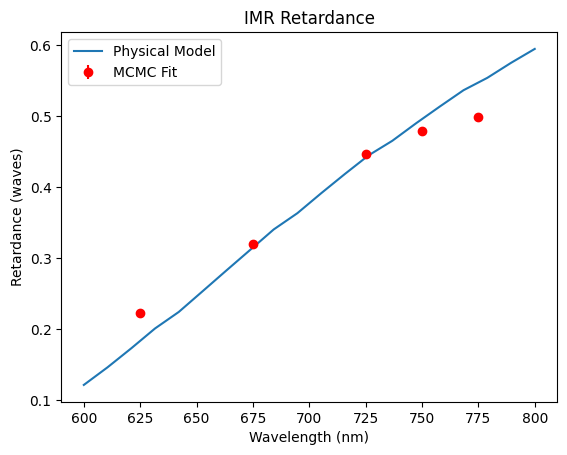

In [26]:
plt.title('IMR Retardance')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Retardance (waves)")
plt.plot(wavelengths, retardances, label = "Physical Model")
MCMC_wavelengths = np.array([625, 675, 725, 750, 775])
MCMC_IMR_retardances = np.array([0.223, 0.32, 0.446, 0.479 ,0.498])
MCMC_IMR_errs = np.array([0.004, 0.003, 0.001, 0.003 ,0.005])
plt.errorbar(MCMC_wavelengths, MCMC_IMR_retardances, yerr = MCMC_IMR_errs, marker = 'o', color = "red", linestyle = "None", label = "MCMC Fit")
plt.legend()

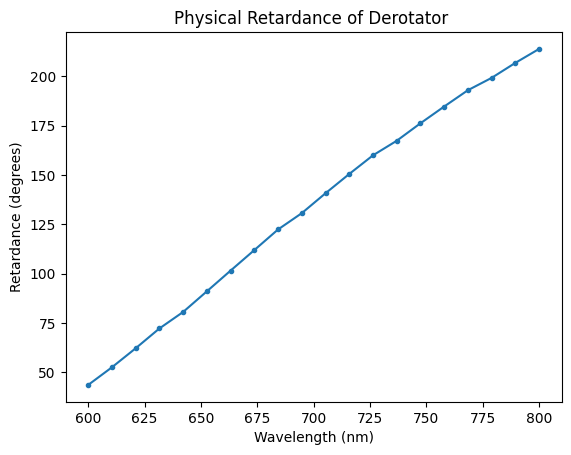

In [27]:
plt.title('Physical Retardance of Derotator ')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Retardance (degrees)")

retardances_degrees = np.degrees(retardances * 2 * np.pi)
plt.plot(wavelengths, retardances_degrees, marker = '.')

In [28]:
np.save(wavelengths, "IMR_wavelengths.npy")
np.save(retardances_degrees, "IMR_retardances.npy")

TypeError: expected str, bytes or os.PathLike object, not ndarray

In [ ]:
print(np.max(retardances_degrees))

302.56416190480735


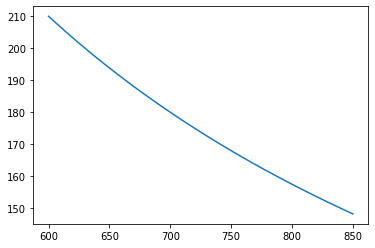

In [ ]:
wavelengths = np.linspace(600, 850, 100)
FLC_retardances = np.degrees(2 * np.pi * MCMC_SetUp.FLC_retardance(np.zeros(len(wavelengths)) + 700, wavelengths))
plt.plot(wavelengths, FLC_retardances)